### 第一题

作业要求描述：

使用本课程提供的中文新闻语料库，并利用`scikit-learn`中的聚类算法进行中文新闻聚类。完成以下任务：

1. **构造新闻数据集**：参考课件配套的聚类代码，构造用于聚类的新闻数据集。请注意，不能直接使用与课件中完全相同的文本数据，应进行适当的修改和扩展。

2. **聚类算法应用**：使用K-均值（K-Means）和层次聚类（HAC）算法对构建的新闻数据集进行聚类。鼓励使用其他聚类算法进行尝试和对比。

3. **算法效果评价**：
    - 计算聚类结果的外部和内部评价指标。
    - 在类簇数`K`相同时，对比不同算法设定下的聚类结果评价指标得分差异，并对结果进行简要描述和分析。

4. **类簇数变化分析**：
    - 在相同的算法设定下，对比类簇数`K`变化时的聚类结果评价指标得分差异，并对结果进行简要描述和分析。
    - 请绘制横轴为类簇数`K`，纵轴为所选评价指标的分析图表。

**注意事项**：

1. **算法设定的多样性**：不同的算法设定可以包括但不限于：文本向量化方法不同、聚类算法不同、聚类算法的参数不同等。
2. **对比分析要求**：
    - 第3小题：至少对比三种不同的算法设定。
    - 第3小题：至少选择一种外部评价指标和一种内部评价指标进行对比分析。
    - 第4小题：至少选择一种外部评价指标和一种内部评价指标进行对比分析，并使用图表展示结果。
3. **数据来源**：请使用以下链接下载中文新闻语料库：https://www.kaggle.com/datasets/jianzhangzhang/text-mining-course-data?select=cn_news_tagged

**参考资料**：

1. 课件和课件配套代码。

In [1]:
### 请在这里写你的答案

## 导入所需包

In [2]:
from nltk.corpus.reader import CategorizedTaggedCorpusReader
import re
import string
from sklearn.cluster import AgglomerativeClustering
import fasttext
from sklearn.cluster import KMeans
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import random
random.seed(2024)
from sklearn.cluster import Birch
from sklearn.mixture import GaussianMixture
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

## 预处理文本

In [3]:
creader = CategorizedTaggedCorpusReader('./cn_news_tagged/', '.*',cat_pattern = r'(.+)/.+txt')

In [4]:
lable = []
for idx,category in enumerate(creader.categories()):
    print(idx, category)
    lable.append(category)

0 Culture
1 Education
2 Finance
3 Health
4 IT
5 Military
6 Recruit
7 Sports
8 Travel


In [5]:
zh_char = re.compile(r'[\u4e00-\u9fa5]')

In [6]:
with open('./stopwords.txt') as f:
    stopwords = f.read().strip().split()

In [7]:
extra_stopwords = ['没有','什么','不是','记者']

In [8]:
def preprocess(text):
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    words = text.split()
    words = [word for word in words if word not in stopwords + extra_stopwords and len(zh_char.findall(word)) > 1]
    return words

In [9]:
news_doc = []
news_lable = []
for category in lable:
    print('Processing {}'.format(category),end='\t')
    news_files = creader.fileids(categories=[category])
    assert len(news_files) > 100
    random.shuffle(news_files)
    for file_id in tqdm(news_files[:100]):
        doc = creader.words(fileids=[file_id])
        documents = [preprocess(document) for document in doc]
        documents = [i for i in documents if i != []]
        documents = [','.join(i) for i in documents]
        news_doc.append(documents)
        news_lable.append(category)

assert len(news_doc) == 900

Processing Culture	

100%|██████████| 100/100 [00:02<00:00, 46.70it/s]


Processing Education	

100%|██████████| 100/100 [00:01<00:00, 62.03it/s]


Processing Finance	

100%|██████████| 100/100 [00:01<00:00, 97.11it/s]


Processing Health	

100%|██████████| 100/100 [00:01<00:00, 76.85it/s]


Processing IT	

100%|██████████| 100/100 [00:00<00:00, 104.16it/s]


Processing Military	

100%|██████████| 100/100 [00:01<00:00, 83.56it/s]


Processing Recruit	

100%|██████████| 100/100 [00:01<00:00, 66.02it/s]


Processing Sports	

100%|██████████| 100/100 [00:00<00:00, 123.09it/s]


Processing Travel	

100%|██████████| 100/100 [00:00<00:00, 109.00it/s]


## 加载模型

In [10]:
zh_embeddings = fasttext.load_model("./cc.zh.300.bin")

In [11]:
news_vec = np.zeros((900,300))

In [12]:
for idx,doc in enumerate(news_doc):
    doc_vec = zh_embeddings.get_sentence_vector(' '.join(doc))
    doc_norm = np.linalg.norm(doc_vec)
    # 模长归一化
    if doc_norm == 0:
        normalized_doc_vector = doc_vec
    else:
        normalized_doc_vector = doc_vec / doc_norm
        
    news_vec[idx] = normalized_doc_vector

## TF-IDF词向量

In [13]:
vectorizer = TfidfVectorizer(tokenizer=lambda text:text, lowercase=False, min_df = 5)
news_vec_tfidf = vectorizer.fit_transform(news_doc)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## 定义算法函数

In [14]:
def kmeans(news_vec, true_k):
    model = KMeans(n_clusters=true_k, max_iter=500, n_init='auto', random_state=2024)
    model.fit(news_vec)
    doc_labels = model.predict(news_vec)
    return doc_labels

In [15]:
def hac_tfidf(news_vec, true_k):
    model= AgglomerativeClustering(n_clusters=true_k, metric = 'euclidean', linkage = 'complete')
    doc_labels = model.fit_predict(news_vec.toarray())
    return doc_labels

In [16]:
def hac_fasttext(news_vec, true_k):
    model = AgglomerativeClustering(n_clusters=true_k, metric = 'euclidean', linkage = 'complete')
    doc_labels = model.fit_predict(news_vec)
    return doc_labels

In [17]:
def gmm(news_vec, true_k):
    model = GaussianMixture(n_components= true_k, random_state=2024)
    model.fit(news_vec)
    doc_labels = model.predict(news_vec)
    return doc_labels

In [18]:
def birch(news_vec, true_k):
    model = Birch(threshold=0.1, n_clusters=true_k)
    model.fit(news_vec)
    doc_labels = model.predict(news_vec)
    return doc_labels

In [42]:
def top_term_of_cluster(true_k, news_vec,doc_labels):
    print("Top terms per cluster:")
    terms = vectorizer.get_feature_names_out()
    for i in range(true_k):
        print("Cluster %d:" % i, end='')
        doc_idxs = np.where(doc_labels==i)[0]
        cluster_vec = news_vec[doc_idxs]
        centroid_tfidf = np.mean(cluster_vec, axis=0)
        order_centroid = centroid_tfidf.argsort()[::-1]
        for ind in order_centroid[:10]:
            print(' %s' % terms[ind], end='')
        print()

In [ ]:
print("Top terms per cluster:")
terms = vectorizer.get_feature_names_out()
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    doc_idxs = np.where(doc_labels==i)[0]
    cluster_vec_tfidf = news_vec_tfidf[doc_idxs].toarray()
    centroid_tfidf = np.mean(cluster_vec_tfidf, axis=0)
    order_centroid = centroid_tfidf.argsort()[::-1]
    # 每个簇打印前10个关键词
    for ind in order_centroid[:10]:
        print(' %s' % terms[ind], end='')
    print()

In [39]:
def top_term_of_cluster_tfidf(true_k, news_vec):
    model= AgglomerativeClustering(n_clusters=true_k, metric = 'euclidean', linkage = 'complete')
    model.fit_predict(news_vec.toarray())
    print("Top terms per cluster:")
    terms = vectorizer.get_feature_names_out()
    for i in range(true_k):
        print("Cluster %d:" % i, end='')
        doc_idxs = np.where(model.labels_==i)[0]
        cluster_vec_tfidf = news_vec[doc_idxs].toarray()
        centroid_tfidf = np.mean(cluster_vec_tfidf, axis=0)
        order_centroid = centroid_tfidf.argsort()[::-1]
        # 每个簇打印前10个关键词
        for ind in order_centroid[:10]:
            print(' %s' % terms[ind], end='')
        print()

In [20]:
def pca_fasttext(news_vec):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(news_vec)
    return(reduced_data)

In [21]:
def pca_tfidf(news_vec_tfidf):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(news_vec_tfidf.toarray())
    return(reduced_data)

In [22]:
def matplot(true_k, reduced_data, doc_labels):
    plt.figure(figsize=(8, 6))
    colors = ['red', 'green', 'blue', 'yellow', 'cyan', 'black', 'm', 'pink', 'orange']
    for i in range(true_k):
        # 提取每个聚类的数据点
        points = reduced_data[doc_labels == i]
        plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[i], label=f'Cluster {i}')
    plt.title('Document Clusters')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.legend()
    plt.show()

In [23]:
true_k = 9
kmeans_labels = {}
for i in range(3,true_k + 1):
    lable = kmeans(news_vec, i)
    kmeans_labels[i] = lable

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

In [24]:
gmm_labels = {}
for i in range(3,true_k + 1):
    lable = gmm(news_vec, i)
    gmm_labels[i] = lable

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

In [25]:
hac_tfidf_labels = {}
for i in range(3,true_k + 1):
    lable = hac_tfidf(news_vec_tfidf, i)
    hac_tfidf_labels[i] = lable

In [26]:
hac_fasttext_labels = {}
for i in range(3,true_k + 1):
    lable = hac_fasttext(news_vec, i)
    hac_fasttext_labels[i] = lable

In [27]:
briche_labels = {}
for i in range(3,true_k + 1):
    lable = birch(news_vec, i)
    briche_labels[i] = lable

In [40]:
top_term_of_cluster_tfidf(true_k, news_vec_tfidf)

Top terms per cluster:
Cluster 0: 企业 公司 教育 中国 考试 市场 价格 管理 工作 机构
Cluster 1: 生活 男人 作品 喜欢 心理 影片 教堂 感动 故事 仪式
Cluster 2: 工作 学生 食物 简历 大学 面试 毕业 人才 公司 国家队
Cluster 3: 公司 旅游 招生 大学 专业 录取 股东 手机 微软 考生
Cluster 4: 日本 中国 美国 导弹 公司 战机 美军 俄罗斯 飞行 中国队
Cluster 5: 文化 中国 市场 发展 国家 社会 创新 博客 产品 历史
Cluster 6: 孩子 行情 老板 公司 家长 老师 军事 训练 论坛 基金
Cluster 7: 比赛 主场 俱乐部 分钟 足协 对手 球员 赛季 球队 联赛
Cluster 8: 开奖 中奖 本期 软件 名牌 注数 检查 数据 平局 开出


In [43]:
top_term_of_cluster(true_k, news_vec, kmeans_labels[9])

Top terms per cluster:
Cluster 0: 与会 3月份 不好意思 一般来说 一日 上班 三角洲 一流 不愧 三级
Cluster 1: 与会 3月份 不好意思 上升 不俗 一般来说 上班 不乏 三角洲 一半
Cluster 2: 与会 3月份 不好意思 一般来说 不在乎 个性 上升 三军 上班 一批
Cluster 3: 与会 3月份 不好意思 一般来说 个性 三级 不在乎 两会 一流 上升
Cluster 4: 与会 3月份 不好意思 一般来说 上升 个性 一半 世上 三级 一流
Cluster 5: 与会 3月份 不好意思 一般来说 上班 上升 严肃 个性 不在乎 上行
Cluster 6: 与会 3月份 不好意思 一般来说 上升 不俗 一流 三级 严厉 上月
Cluster 7: 与会 3月份 不好意思 上班 上升 一般来说 不俗 个性 不在乎 上报
Cluster 8: 与会 3月份 不好意思 一般来说 上升 上班 三级 业界 一类 一批


In [ ]:
# 真实类别标签为字符串，将字符串标签转换为整数
label_encoder = LabelEncoder()
true_labels_encoded = label_encoder.fit_transform(news_lable)

In [ ]:
def purity_score(y_true, y_pred):
    # 构造一个混淆矩阵
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # 返回纯度
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

In [ ]:
purity = purity_score(true_labels_encoded, kmeans_labels[9])
print(f"Purity: {purity:.4f}")

Purity: 0.6967


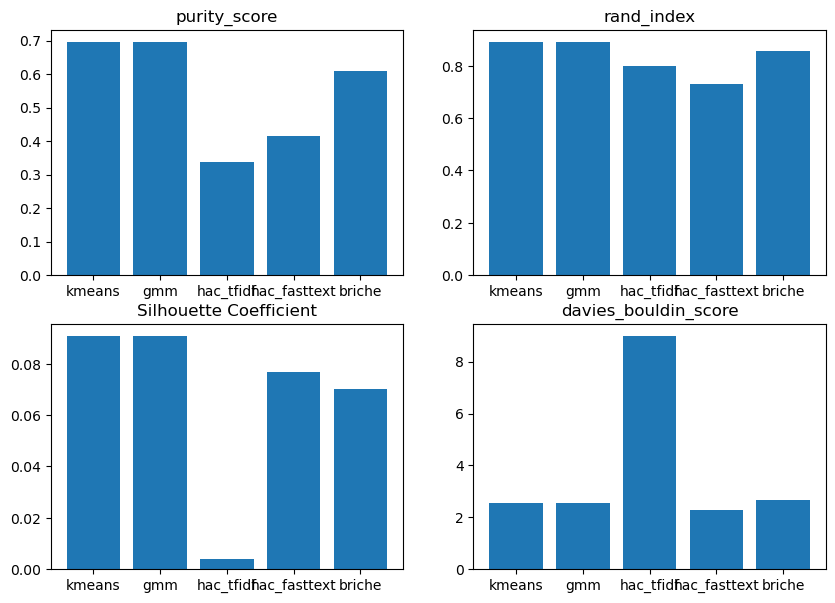

In [ ]:
fig = plt.figure(1, figsize=(10, 7))
x = ['kmeans', 'gmm', 'hac_tfidf', 'hac_fasttext', 'briche']

y = []
for i in kmeans_labels[9], gmm_labels[9], hac_tfidf_labels[9], hac_fasttext_labels[9], briche_labels[9]:
    socre = purity_score(true_labels_encoded, i)
    y.append(round(socre, 6))
plt.subplot(2, 2, 1)
plt.bar(x, y)
plt.title("purity_score")

y = []
for i in kmeans_labels[9], gmm_labels[9], hac_tfidf_labels[9], hac_fasttext_labels[9], briche_labels[9]:
    socre = metrics.rand_score(true_labels_encoded, i)
    y.append(round(socre, 6))
plt.subplot(2, 2, 2)
plt.bar(x, y)
plt.title("rand_index")

y = []
for i in kmeans_labels[9], gmm_labels[9], hac_tfidf_labels[9], hac_fasttext_labels[9], briche_labels[9]:
    if i is hac_tfidf_labels[9]:
        socre = metrics.silhouette_score(news_vec_tfidf.toarray(), i)
    else:
        socre = metrics.silhouette_score(news_vec, i)
    y.append(round(socre, 6))
plt.subplot(2, 2, 3)
plt.bar(x, y)
plt.title("Silhouette Coefficient")

y = []
for i in kmeans_labels[9], gmm_labels[9], hac_tfidf_labels[9], hac_fasttext_labels[9], briche_labels[9]:
    if i is hac_tfidf_labels[9]:
        socre = metrics.davies_bouldin_score(news_vec_tfidf.toarray(), i)
    else:
        socre = metrics.davies_bouldin_score(news_vec, i)
    y.append(round(socre, 6))
plt.subplot(2, 2, 4)
plt.bar(x, y)
plt.title("davies_bouldin_score")

plt.show()

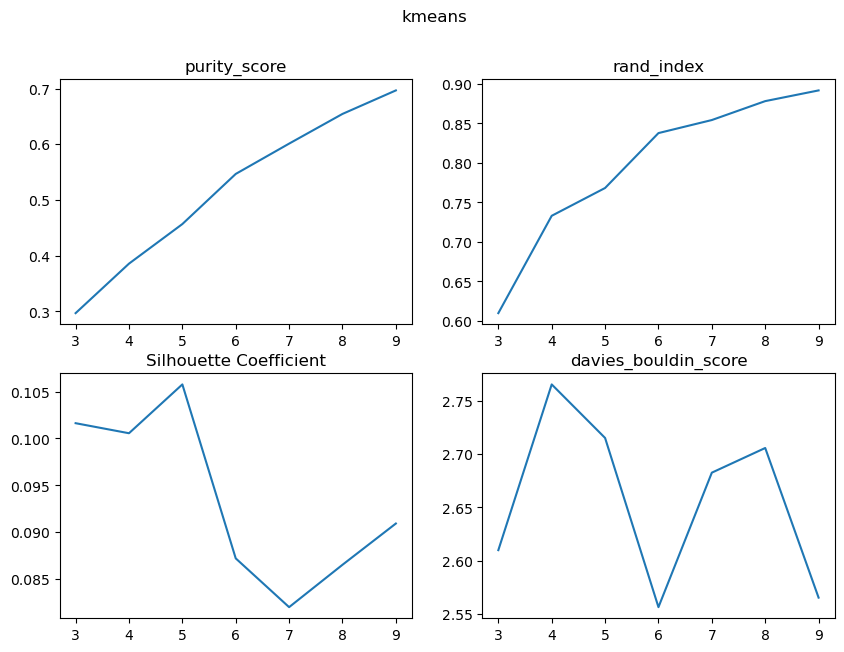

In [ ]:
fig = plt.figure(2, figsize=(10, 7))
x = [3, 4, 5, 6, 7, 8, 9]

y = []
for i,j in kmeans_labels.items():
    socre = purity_score(true_labels_encoded, j)
    y.append(round(socre, 6))
plt.subplot(2, 2, 1)
plt.plot(x, y)
plt.title("purity_score")

y = []
for i,j in kmeans_labels.items():
    socre = metrics.rand_score(true_labels_encoded, j)
    y.append(round(socre, 6))
plt.subplot(2, 2, 2)
plt.plot(x, y)
plt.title("rand_index")

y = []
for i,j in kmeans_labels.items():
    socre = metrics.silhouette_score(news_vec, j)
    y.append(round(socre, 6))
plt.subplot(2, 2, 3)
plt.plot(x, y)
plt.title("Silhouette Coefficient")

y = []
for i,j in kmeans_labels.items():
    socre = metrics.davies_bouldin_score(news_vec, j)
    y.append(round(socre, 6))
plt.subplot(2, 2, 4)
plt.plot(x, y)
plt.title("davies_bouldin_score")

plt.suptitle('kmeans')
plt.show()

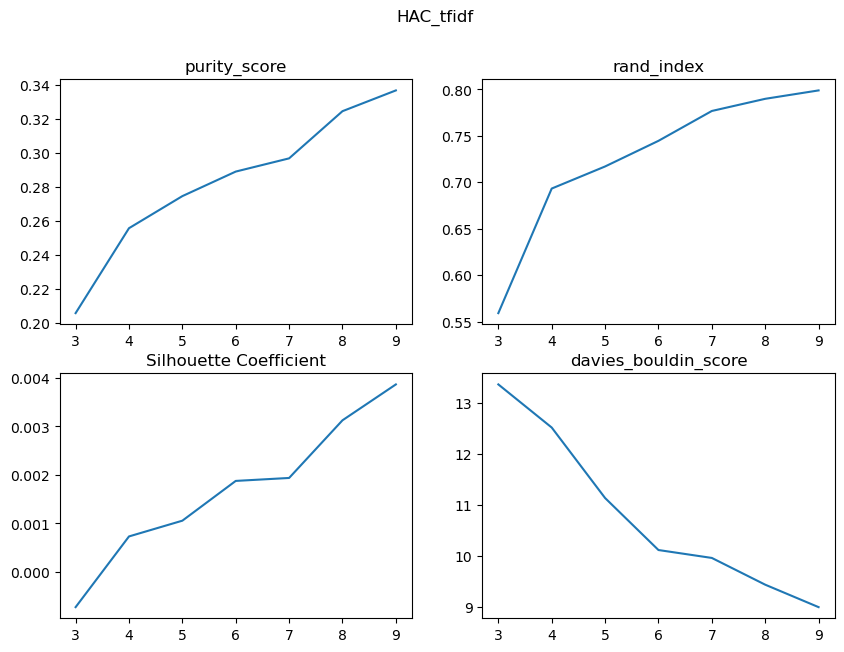

In [ ]:
fig = plt.figure(3, figsize=(10, 7))
x = [3, 4, 5, 6, 7, 8, 9]
    
y = []
for i,j in hac_tfidf_labels.items():
    socre = purity_score(true_labels_encoded, j)
    y.append(round(socre, 6))
plt.subplot(2, 2, 1)
plt.plot(x, y)
plt.title("purity_score")

y = []
for i,j in hac_tfidf_labels.items():
    socre = metrics.rand_score(true_labels_encoded, j)
    y.append(round(socre, 6))
plt.subplot(2, 2, 2)
plt.plot(x, y)
plt.title("rand_index")

y = []
for i,j in hac_tfidf_labels.items():
    socre = metrics.silhouette_score(news_vec_tfidf.toarray(), j)
    y.append(round(socre, 6))
plt.subplot(2, 2, 3)
plt.plot(x, y)
plt.title("Silhouette Coefficient")

y = []
for i,j in hac_tfidf_labels.items():
    socre = metrics.davies_bouldin_score(news_vec_tfidf.toarray(), j)
    y.append(round(socre, 6))
plt.subplot(2, 2, 4)
plt.plot(x, y)
plt.title("davies_bouldin_score")

plt.suptitle('HAC_tfidf')
plt.show()

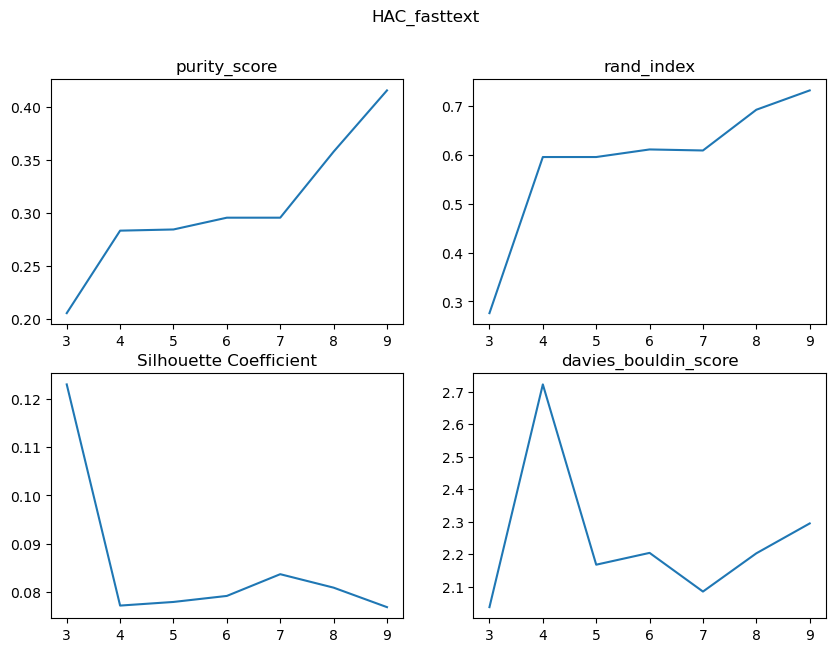

In [ ]:
fig = plt.figure(4, figsize=(10, 7))
x = [3, 4, 5, 6, 7, 8, 9]
    
y = []
for i,j in hac_fasttext_labels.items():
    socre = purity_score(true_labels_encoded, j)
    y.append(round(socre, 6))
plt.subplot(2, 2, 1)
plt.plot(x, y)
plt.title("purity_score")

y = []
for i,j in hac_fasttext_labels.items():
    socre = metrics.rand_score(true_labels_encoded, j)
    y.append(round(socre, 6))
plt.subplot(2, 2, 2)
plt.plot(x, y)
plt.title("rand_index")

y = []
for i,j in hac_fasttext_labels.items():
    socre = metrics.silhouette_score(news_vec, j)
    y.append(round(socre, 6))
plt.subplot(2, 2, 3)
plt.plot(x, y)
plt.title("Silhouette Coefficient")

y = []
for i,j in hac_fasttext_labels.items():
    socre = metrics.davies_bouldin_score(news_vec, j)
    y.append(round(socre, 6))
plt.subplot(2, 2, 4)
plt.plot(x, y)
plt.title("davies_bouldin_score")

plt.suptitle('HAC_fasttext')
plt.show()

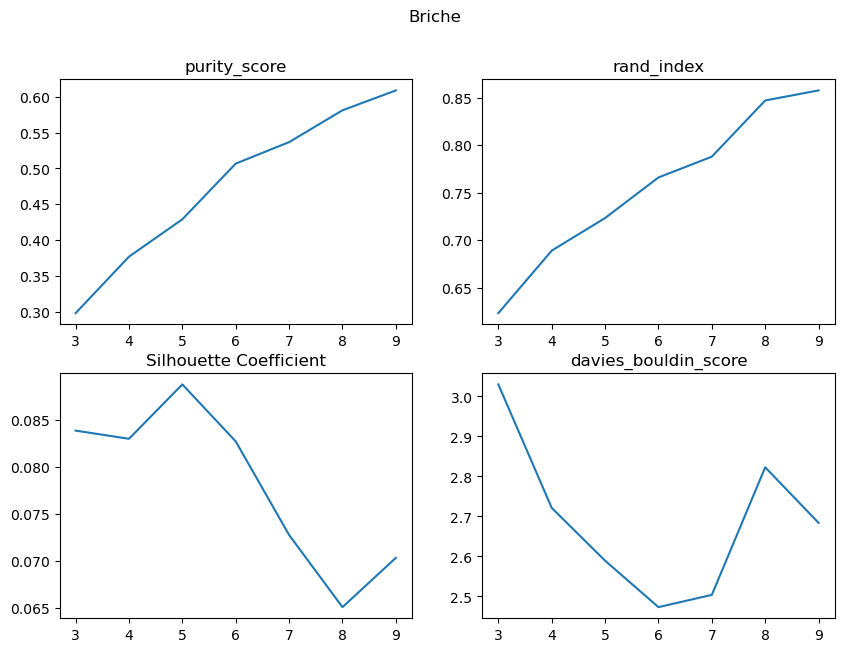

In [ ]:
fig = plt.figure(4, figsize=(10, 7))
x = [3, 4, 5, 6, 7, 8, 9]
    
y = []
for i,j in briche_labels.items():
    socre = purity_score(true_labels_encoded, j)
    y.append(round(socre, 6))
plt.subplot(2, 2, 1)
plt.plot(x, y)
plt.title("purity_score")

y = []
for i,j in briche_labels.items():
    socre = metrics.rand_score(true_labels_encoded, j)
    y.append(round(socre, 6))
plt.subplot(2, 2, 2)
plt.plot(x, y)
plt.title("rand_index")

y = []
for i,j in briche_labels.items():
    socre = metrics.silhouette_score(news_vec, j)
    y.append(round(socre, 6))
plt.subplot(2, 2, 3)
plt.plot(x, y)
plt.title("Silhouette Coefficient")

y = []
for i,j in briche_labels.items():
    socre = metrics.davies_bouldin_score(news_vec, j)
    y.append(round(socre, 6))
plt.subplot(2, 2, 4)
plt.plot(x, y)
plt.title("davies_bouldin_score")

plt.suptitle('Briche')
plt.show()